# Resnet34

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import keras
from keras import backend as k
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense,Flatten,Dropout
from keras.optimizers import Adam, RMSprop,SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from IPython.display import display
from PIL import Image
%matplotlib inline

In [3]:
#Assigning paths
train_path = '../Dataset/train/'
valid_path = '../Dataset/validation/'
test_path = '../Dataset/test/'

In [4]:
# plotting images with labels
def plots(ims, figsize=(12,6), rows=2, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1]!=3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims)%2==0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i],fontsize=16)
        plt.imshow(ims[i],interpolation = None if interp else 'none')

In [5]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
       rotation_range=20,
       width_shift_range=0.2,
       height_shift_range=0.2,
       horizontal_flip=True,
       fill_mode='nearest'
)
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 16
val_batchsize = 16
test_batchsize = 10
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(256, 256),
        batch_size=train_batchsize,
        classes =['Black_Measles','Blackrot','Isariopsis',"MDB_disease","No_disease","Spyder","mildiou"]
        )
 
validation_generator = validation_datagen.flow_from_directory(
        valid_path,
        target_size=(256, 256),
        batch_size=val_batchsize,
        classes=['Black_Measles','Blackrot','Isariopsis',"MDB_disease","No_disease","Spyder","mildiou"]
        ,
        shuffle=True)
test_generator = validation_datagen.flow_from_directory(test_path,
        target_size=(256, 256),
        batch_size=val_batchsize,
        classes =['Black_Measles','Blackrot','Isariopsis',"MDB_disease","No_disease","Spyder","mildiou"]
        ,
        shuffle=False)

Found 11200 images belonging to 7 classes.
Found 2800 images belonging to 7 classes.
Found 70 images belonging to 7 classes.


In [7]:
from classification_models.keras import Classifiers
from keras.layers import GlobalAveragePooling2D,Flatten
from keras.models import Model
ResNet34, preprocess_input = Classifiers.get('resnet34')

n_classes = 7

# build model
base_model = ResNet34(input_shape=(256,256,3), weights='imagenet', include_top=False)
model =Sequential()
model.add(base_model)
headModel = model.output

headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(7, activation="softmax")(headModel)
model = Model(inputs=model.input, outputs=headModel)



In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3_input (InputLayer)   (None, 256, 256, 3)       0         
_________________________________________________________________
model_3 (Model)              (None, 8, 8, 512)         21302473  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [9]:
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [10]:
# Save the model according to the conditions  
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

checkpoint = ModelCheckpoint("../saved_models/resnet34.h5", monitor='loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=1, mode='auto')


In [13]:
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,initial_epoch=0,epochs=50,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1, callbacks=([early,checkpoint]))

Epoch 1/50
700/700 [==============================] - 264s 378ms/step - loss: 0.8046 - acc: 0.7309 - val_loss: 0.2249 - val_acc: 0.9186

Epoch 00001: loss improved from inf to 0.80461, saving model to ../saved_models/resnet34.h5
Epoch 2/50
700/700 [==============================] - 256s 366ms/step - loss: 0.2913 - acc: 0.9042 - val_loss: 0.1519 - val_acc: 0.9471

Epoch 00002: loss improved from 0.80461 to 0.29133, saving model to ../saved_models/resnet34.h5
Epoch 3/50
700/700 [==============================] - 256s 366ms/step - loss: 0.2070 - acc: 0.9324 - val_loss: 0.1172 - val_acc: 0.9618

Epoch 00003: loss improved from 0.29133 to 0.20703, saving model to ../saved_models/resnet34.h5
Epoch 4/50
700/700 [==============================] - 256s 366ms/step - loss: 0.1578 - acc: 0.9496 - val_loss: 0.1052 - val_acc: 0.9686

Epoch 00004: loss improved from 0.20703 to 0.15782, saving model to ../saved_models/resnet34.h5
Epoch 5/50
700/700 [==============================] - 257s 366ms/step - 

700/700 [==============================] - 263s 376ms/step - loss: 0.0174 - acc: 0.9938 - val_loss: 0.0538 - val_acc: 0.9914

Epoch 00040: loss improved from 0.01806 to 0.01737, saving model to ../saved_models/resnet34.h5
Epoch 41/50
700/700 [==============================] - 261s 373ms/step - loss: 0.0153 - acc: 0.9954 - val_loss: 0.0525 - val_acc: 0.9911

Epoch 00041: loss improved from 0.01737 to 0.01534, saving model to ../saved_models/resnet34.h5
Epoch 42/50
700/700 [==============================] - 260s 372ms/step - loss: 0.0157 - acc: 0.9950 - val_loss: 0.0567 - val_acc: 0.9911

Epoch 00042: loss did not improve from 0.01534
Epoch 43/50
700/700 [==============================] - 280s 400ms/step - loss: 0.0193 - acc: 0.9938 - val_loss: 0.0596 - val_acc: 0.9889

Epoch 00043: loss did not improve from 0.01534
Epoch 44/50
700/700 [==============================] - 268s 383ms/step - loss: 0.0137 - acc: 0.9954 - val_loss: 0.0451 - val_acc: 0.9918

Epoch 00044: loss improved from 0.01

In [14]:
import pickle

# save the model to disk
filename = '../saved_models/resnet34.sav'
pickle.dump(model, open(filename, 'wb'))

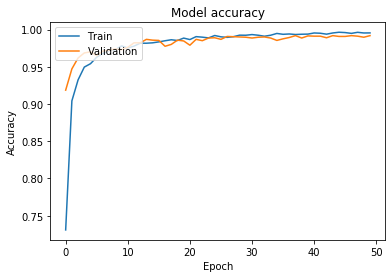

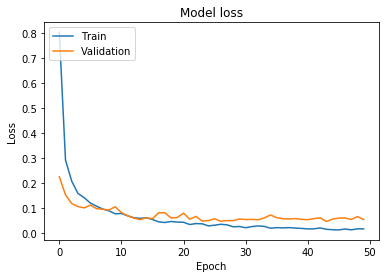

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
from sklearn.metrics import classification_report
print("[INFO] evaluating after fine-tuning network...")
test_generator.reset()
pred = model.predict_generator(test_generator)
pred = np.argmax(pred, axis=1)
print(classification_report(test_generator.classes, pred,target_names=test_generator.class_indices.keys()))
 

[INFO] evaluating after fine-tuning network...
               precision    recall  f1-score   support

Black_Measles       1.00      1.00      1.00        10
     Blackrot       1.00      1.00      1.00        10
   Isariopsis       1.00      1.00      1.00        10
  MDB_disease       1.00      1.00      1.00        10
   No_disease       1.00      0.90      0.95        10
       Spyder       0.91      1.00      0.95        10
      mildiou       1.00      1.00      1.00        10

    micro avg       0.99      0.99      0.99        70
    macro avg       0.99      0.99      0.99        70
 weighted avg       0.99      0.99      0.99        70



In [17]:
#Simple program to plot confusion matrix (you can find this in scikit learn documentation)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [22]:
#predict
Prediction = model.predict_generator(test_generator,steps=5)

In [23]:
cm = confusion_matrix(test_generator.classes,Prediction.argmax(axis=1))

Confusion matrix, without normalization
[[10  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0]
 [ 0  0 10  0  0  0  0]
 [ 0  0  0 10  0  0  0]
 [ 0  0  0  0  9  1  0]
 [ 0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0 10]]


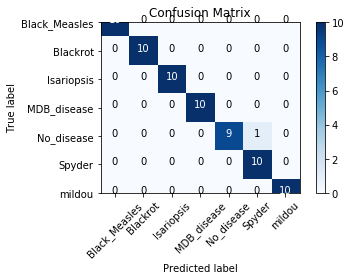

In [24]:
cm_plot_labels = ['Black_Measles','Blackrot','Isariopsis',"MDB_disease","No_disease","Spyder","mildou"]
plot_confusion_matrix(cm,cm_plot_labels,title = 'Confusion Matrix')

# Testing

In [3]:
from keras.models import load_model

model = load_model('../saved_models/resnet34.h5')

In [4]:
import cv2
import imutils
import numpy as np
# load the input image and then clone it so we can draw on it later
image = cv2.imread('../Dataset/test/Spyder/1_spyder134 resized.jpg')
output = image.copy()
output = imutils.resize(output, width=400)
 
# our model was trained on RGB ordered images but OpenCV represents
# images in BGR order, so swap the channels, and then resize to
# 224x224 (the input dimensions for VGG16)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256))

image = np.reshape(image,[1,256,256,3]) 
image = image.astype("float32")/255


#predict
pred = model.predict(image)


#list the classes
classes =['Black_Measles','Blackrot','Isariopsis',"MDB_disease","No_disease","Spyder","mildiou"]

#label
i = np.argmax(pred)
label = classes[i]

# draw the prediction on the output image
text = "{}: {:.2f}%".format(label, pred.item(i) * 100)
cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0, 0, 255), 2)
# show the output image
cv2.imshow("Output", output)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
import cv2
from keras.models import load_model
import numpy as np
import imutils
from PIL import Image
import copy

#list the classes
classes =['Black_Measles','Blackrot','Isariopsis',"MDB_disease","No_disease","Spyder","mildiou"]

video = cv2.VideoCapture(0)

while True:
        _, frame = video.read()

        #Convert the captured frame into RGB

        output = copy.copy(frame)
        #output = imutils.resize(output, width=400)

# our model was trained on RGB ordered images but OpenCV represents
# images in BGR order, so swap the channels, and then resize to
# 224x224 (the input dimensions for VGG16)
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))

        image = np.reshape(image,[1,256,256,3]) 
        image = image.astype("float32")/255

        preds = model.predict(image)

        #label
        i = np.argmax(preds)
        label = classes[i]

        # draw the prediction on the output image
        text = "{}: {:.2f}%".format(label, preds.item(i) * 100)
        cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0, 0, 255), 2)
        # show the output image
        cv2.imshow("Output", output)
        key = cv2.waitKey(1)
        if key ==ord('q'):
            break

video.release()
cv2.destroyAllWindows()      